# 第十章 LoRA微调与模型量化

## 10.1 简介

随着GPT、Llama、Stable Diffusion等大型预训练模型（Large Language Models, LLMs）的崛起，其卓越的通用能力为各行各业带来了革命性的变革与机遇。然而，要将这些强大的通用模型精准适配于特定的业务场景或个性化需求，微调（Fine-tuning）是不可或缺的关键步骤。但对于广大开发者、中小型企业乃至部分研究机构而言，对参数量动辄数十亿、上千亿的大模型进行传统的“全参数微调”，在计算资源和存储成本上都是一项几乎不可能完成的挑战。

我们可以将一个庞大的预训练模型（如GPT-3）想象成一个知识渊博、经验丰富的“超级大脑”。若想让这个“大脑”掌握一项全新的、具体的技能（例如，扮演特定角色进行对话，或理解某一专业领域的术语），传统的“全参数微调”（Full Fine-tuning）方法要求我们更新“大脑”中几乎所有的神经元连接（即模型的全部参数）。这不仅需要海量的计算能力（如顶级的GPU集群）和巨大的存储空间，训练过程也同样耗时且昂贵。

为解决这一难题，本章将深入介绍LoRA（Low-Rank Adaptation）——一种高效、轻量化的参数高效微调（Parameter-Efficient Fine-tuning, PEFT）技术。LoRA的核心思想是**“冻结”预训练模型的绝大部分原始参数，仅在模型中注入少量、可训练的“低秩”矩阵**来巧妙地适应新任务。这种方法好比是为“超级大脑”安装了一个小巧而高效的“插件”，使其能够在不改变原有知识结构的基础上，快速掌握新技能。通过这种方式，我们得以用极低的成本，实现对大模型的个性化定制与优化。

然而，高效微调仅仅解决了“训练”阶段的资源难题。当我们希望将微调后的模型部署到实际应用中，尤其是部署在消费级硬件、边缘设备或移动端时，模型本身巨大的体积和推理时的高显存占用成为了新的瓶颈。这时，**模型量化（Quantization）** 技术便应运而生。量化通过降低模型参数的数值精度（例如，从32位浮点数转换为8位或4位整数），在几乎不影响模型性能的前提下，大幅压缩模型大小、降低显存消耗并加速推理速度。它为大模型走出数据中心、落地于更广泛的场景提供了可能。

本章将结合LoRA与模型量化这两大关键技术，为您揭示如何在有限的资源下，高效地完成大模型的“训练”与“部署”全流程。

<figure style="text-align: center;">
    <img src="./png_chap10/introduction.png">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图1：LoRA微调与模型量化技术概览
  </figcaption>
</figure>


**本章重点内容：**

- LoRA的核心原理： 探究低秩适应（Low-Rank Adaptation）背后的核心思想，理解其如何通过少量可训练参数来模拟全参数微调的效果
- LoRA的实战应用： 学习如何将LoRA技术应用于主流的大型语言模型或文生图模型，并掌握其在具体任务中的配置与训练流程
- 模型量化的价值： 探讨在资源受限的环境下（如消费级显卡或移动设备），模型量化（Quantization）作为关键压缩技术的原理及其对推理性能的提升

## 10.2 大模型微调的难点

大模型微调的难点主要集中在资源瓶颈、训练效率和后续部署三大方面。

直接微调一个拥有数十亿甚至上千亿参数的预训练模型，意味着需要更新模型中的每一个权重。这在理论上是让模型“全身心”学习新知识的最佳方式，但在实践中会遇到巨大的算力和存储壁垒。一个新人开发者或一个预算有限的团队，面对动辄需要数台顶级GPU、耗时数周的训练过程，往往会望而却步。这种资源上的巨大鸿沟，成为了阻碍大模型技术普及和创新的核心痛点。

下面是传统微调技术在现代遇到的挑战：

| **挑战类别**   | **具体问题描述**                                             | **产生的影响**                                               |
| -------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| **显存瓶颈**   | 微调需同时存储模型权重、梯度、优化器状态（如Adam）和激活值。 | 显存需求巨大（如7B模型超60GB），远超单张消费级/专业级GPU容量，导致个人和小型团队无法进行微调。 |
| **计算与成本** | 对数十亿参数进行完整的前向和反向传播，计算量极大，且需长期占用昂贵的高端GPU。 | 训练周期长达数天或数周，拖慢研发速度；经济成本高昂，构成巨大的财务壁垒。 |
| **部署与存储** | 每个微调任务都需要保存一个完整的模型副本，导致存储空间急剧膨胀；多任务服务需加载多个大模型。 | 造成巨大的存储资源浪费和管理复杂性；生产环境部署困难，服务延迟高，效率低下。 |
| **训练质量**   | 1. **灾难性遗忘**：模型忘记预训练学到的通用知识。 <br> 2. **过拟合**：模型仅“背诵”微调数据，泛化能力差。 | 模型在通用任务上表现下降；对新数据的适应能力弱，实际应用价值受损。 |


上述种种困难表明，传统的全参数微调技术在大模型时代已经变得不切实际，我们需要更为高效的技术来微调模型。 **参数高效微调（Parameter-Efficient Fine-Tuning，PEFT）** 应运而生，可以有效地解决上面的问题。

## 10.3 LoRA 微调原理

### 10.3.1 概述

一般来说，LoRA重点微调Transformer架构中的自注意力模块里的**查询**权重矩阵和**值**权重矩阵，即$W_q$和$W_v$。有时也会包含对**键**矩阵$W_k$和**输出**矩阵$W_o$的微调。


LoRA的设计思路是在原始的预训练参数中加入旁路，该旁路由低秩矩阵A和B组成。开始训练前，矩阵A采用随机化高斯分布进行初始化，矩阵B则直接初始化为0矩阵。在训练过程中，冻结原模型的参数（即$W_0$），只对低秩矩阵A和低秩矩阵B进行训练操作。在训练结束后，将矩阵B和矩阵A的乘积BA与原模型参数相加，从而得到经过微调的最终模型参数。

<figure style="text-align: center;">
    <img src="./png_chap10/LoRA.png">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图2：LoRA微调示意图
  </figcaption>
</figure>

### 10.3.2 LoRA参数更新示例

假设原模型参数矩阵$W_0$的大小为$d \times k$，低秩矩阵B的大小为$d \times r$，低秩矩阵A的大小为$r \times k$，且 $r << \min(d, k)$。设更新后的模型参数为$W_1$，$\triangle W$代表需要更新的参数。

则模型的参数更新计算方式如下式：

$W_1 = W_0 + \triangle W = W_0 + BA$

其中，我们只需要训练矩阵A和矩阵B。

在秩r的选择上，一般选择1、2、4、8。针对领域跨度较大的任务，可以适当增大秩r的数值。

### 10.3.3 有关LoRA微调的常见问题

- 我们应该对Transformer中的哪些权重矩阵应用LoRA？

   根据《LoRA: Low-Rank Adaptation of Large Language Models》论文中的实验和分析，我们没有必要对Transformer中的所有权重矩阵都应用LoRA，最有效且参数效率最高的策略是仅对自注意力模块中的权重矩阵应用LoRA。为了在性能和效率之间取得最佳平衡，应优先且主要将LoRA应用于Transformer注意力层中的$W_q$和$W_v$矩阵。这已经足够捕获下游任务所需的核心知识调整，同时最大化地节省了可训练参数。

- 我们一般如何确定秩r的取值？

   论文的实验表明，对于大型语言模型(如GPT-3 175B)，r=1或r=2这样小的值就已经能够取得非常好的结果，性能显著优于其他参数高效微调方法。对于RoBERTa、DeBERTa等模型，r=8也被证明是一个非常强的设定。虽然增加r会引入更多的可训练参数，让模型有更大的调整空间，但实验表明，当r超过某个较小的值（如4或8）后，性能的提升会迅速减缓，收益递减。从实际应用的角度来看，我们通常会从一个很小的秩（比如r=4或r=8）开始尝试。如果任务非常复杂或微调效果不佳，可以再适当增加r的值进行实验。选择r是在模型性能和训练成本之间的一种权衡。

- LoRA 的权重矩阵初始化为何采用“高斯分布 + 零”的组合，而不是“双高斯”或“双零”？这背后的原理是什么？

   将 B 初始化为零，无论矩阵 A 如何初始化，其乘积 BA 在初始状态下必然为零矩阵，这意味着在训练的第一步，LoRA模块对模型的改造为零（$ W_0 + \triangle W = W_0 + 0 = W_0 $）。这可以保证微调是从预训练模型的原始状态平稳开始的，避免因随机扰动导致模型在初期输出混乱，具体来说：

   - 如果我们选用“双高斯”初始化，则乘积 BA 将会是一个非零的随机矩阵。这个随机矩阵会作为噪声被直接加到预训练模型的权重上，很可能会严重破坏模型从海量数据中学到的宝贵知识。这种“一上来就胡改”的方式，会使模型在训练初期产生巨大的、无意义的输出，导致训练过程不稳定，甚至可能需要更长的时间才能收敛到理想状态。

   - 如果我们选用“双零”初始化，根据链式法则，我们可以得到 $ \frac{\partial L}{\partial A} = \frac{\partial L}{\partial W} \frac{\partial W}{\partial A} $，由于 $ W = W_0 + BA $，可得 $ \frac{\partial L}{\partial A} = B^T \frac{\partial L}{\partial W} $。因为 B 是零矩阵，所以 $ \frac{\partial L}{\partial A} = 0 $ ，同理可得 $ \frac{\partial L}{\partial B} = 0 $。由此可见，无论训练多少轮，A和B的梯度永远是零，它们的参数不会被更新。

   - 因此，我们采用“高斯分布 + 零”的组合来初始化矩阵

### 10.3.4 LoRA所解决的问题

| 问题类别                | 具体问题描述                                                 | LoRA 解决方案                                                |
| ----------------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| **显存瓶颈**         | 微调大型模型需要为每个任务存储一份完整的模型副本，占用大量显存。 | 冻结预训练模型的权重，仅训练并存储旁路注入的低秩矩阵（A和B）。<br>这些矩阵参数量极小（秩`r`远小于模型维度`d`），可将存储需求降低数千倍。 |
| **计算与时间成本**   | 对整个大型模型进行梯度计算和更新，需要消耗大量的计算资源和时间。 | 在训练中，无需计算庞大的预训练权重的梯度。<br> 计算仅集中在新增的低秩矩阵上，从而显著减少了计算量和训练时间。 |
| **部署与存储难题**   | 为每个下游任务都部署一个独立的、巨大的微调后模型，导致存储和管理的复杂性。 | 共享同一个基础大模型，每个任务仅需一个非常小的LoRA文件。这带来了两个好处：<br>1. **快速切换**：可在一个基础模型上快速加载和切换不同的LoRA模块，以适应不同任务。<br>2. **类比“模型MOD”**：像游戏MOD一样，在同一个基础模型上应用不同的轻量级调整，实现多样化功能。 |
| **训练过程中的问题** | 在小数据集上对大模型进行完全微调时，容易发生“灾难性遗忘”，即模型忘记了在预训练中学到的通用知识。 | 由于原始的预训练权重在训练过程中保持冻结，LoRA有效避免了灾难性遗忘，保留了模型的泛化能力。 |

## 10.4 LoRA高效微调实践

### 10.4.1 环境配置

In [ ]:
!pip install -r requirements.txt

### 10.4.2 加载模型和分词器

在这里我们选择加载模型Qwen2.5-0.5B-Instruct用于示例展示，其中涉及到参数*torch_dtype*，其作用是指定模型加载到内存时使用的**数据类型**(精度).

下面我们用一个小例子来展示使用 `torch.bfloat16` 类型加载模型，其占用的显存要小于使用 `float32` 类型加载的模型。

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

/root/anaconda3/envs/lora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


定义用于打印显存使用情况的函数

In [2]:
def get_memory_in_gb(device):
    """返回指定CUDA设备上已分配的显存，单位为GB"""
    return torch.cuda.memory_allocated(device) / (1024**3)

def print_gpu_memory(stage=""):
    """打印当前已分配的显存"""
    if torch.cuda.is_available():
        # 我们使用 device=0, 即第一张显卡
        memory_gb = get_memory_in_gb(device=0)
        print(f"[{stage}] 当前已分配显存: {memory_gb:.4f} GB")
        
        return memory_gb
    else:
        print("未检测到 CUDA 设备。")

查看使用 `float32` 类型加载模型的显存占用情况

In [3]:
print("\n--- 1. 测试 float32 (默认精度) ---")

# 清理环境，确保测量准确
gc.collect()
torch.cuda.empty_cache()

mem_before = print_gpu_memory("加载前")

# 使用默认精度 (float32) 加载模型
model_fp32 = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32).to(device)

mem_after = print_gpu_memory("加载后")
mem_fp32 = mem_after - mem_before

print(f"模型参数的数据类型: {model_fp32.config.torch_dtype}")


# 清理模型，释放显存
del model_fp32
gc.collect()
torch.cuda.empty_cache()


--- 1. 测试 float32 (默认精度) ---
[加载前] 当前已分配显存: 0.0000 GB
[加载后] 当前已分配显存: 1.8411 GB
模型参数的数据类型: torch.float32


查看使用 `bfloat16` 类型加载模型的显存占用情况

In [4]:
print("\n--- 2. 测试 bfloat16 (半精度) ---")

# 再次清理环境
gc.collect()
torch.cuda.empty_cache()

mem_before = print_gpu_memory("加载前")

# 指定 torch_dtype=torch.bfloat16 来使用半精度加载
model_bf16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16
).to(device)

mem_after = print_gpu_memory("加载后")
mem_bf16 = mem_after - mem_before

print(f"模型参数的数据类型: {model_bf16.config.torch_dtype}")

# 清理模型
del model_bf16
gc.collect()
torch.cuda.empty_cache()


--- 2. 测试 bfloat16 (半精度) ---
[加载前] 当前已分配显存: 0.0000 GB
[加载后] 当前已分配显存: 0.9279 GB
模型参数的数据类型: torch.bfloat16


In [5]:
print(f"Float32 模型占用显存: {mem_fp32:.4f} GB")
print(f"BFloat16 模型占用显存: {mem_bf16:.4f} GB")

ratio = mem_fp32 / mem_bf16
print(f"\nRatio (Float32 / BFloat16): {ratio:.2f}")

Float32 模型占用显存: 1.8411 GB
BFloat16 模型占用显存: 0.9279 GB

Ratio (Float32 / BFloat16): 1.98


结论: 使用 bfloat16 加载模型，占用的显存大约是 float32 的一半。

上面的这个例子很好的说明了，当我们使用不同数据类型加载模型时，其占用的显存大小也会不同。

下面我们将使用 `torch.bfloat16` 数据类型加载模型，并展开后续的微调操作。

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model_save_path = f"{model_name}-local"

model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16, 
    trust_remote_code=True
)
model.to(device)

# 将模型保存到本地
model.save_pretrained(model_save_path)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 将分词器(tokenizer)的填充符(pad_token)设置为句子结束eos_token)
tokenizer.pad_token = tokenizer.eos_token
print("模型和分词器加载完成")

模型和分词器加载完成


### 10.4.3 加载数据集并预处理

这里我们选用一个 [github 开源项目](https://github.com/KMnO4-zx/huanhuan-chat) 中的数据集，其存储在本地 *./dataset_chap10/huanhuan.json* 中，微调后我们将得到模仿甄嬛语气的聊天语言模型。

In [4]:
# 加载数据集

import pandas as pd
from datasets import Dataset

df = pd.read_json('./dataset_chap10/huanhuan.json')
ds = Dataset.from_pandas(df)

print("成功加载数据集")

成功加载数据集


In [5]:
# 查看数据集结构
print(ds)
sample = ds[0]

print("数据集结构及其示例")
print(f"instruction: {sample['instruction']}")
print(f"input: {sample['input']}")
print(f"output: {sample['output']}")

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 3729
})
数据集结构及其示例
instruction: 小姐，别的秀女都在求中选，唯有咱们小姐想被撂牌子，菩萨一定记得真真儿的——
input: 
output: 嘘——都说许愿说破是不灵的。


定义数据预处理函数

In [6]:
def preprocess(example):
    # 设置最大长度
    MAX_LENGTH = 512

    # 指令部分
    instruction_part = f"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n{example['instruction'] + example['input']}<|im_end|>\n<|im_start|>assistant\n"
    # 目标输出部分
    response_part = f"{example['output']}<|im_end|>"

    instruction_ids = tokenizer(instruction_part, add_special_tokens=False)["input_ids"]
    response_ids = tokenizer(response_part, add_special_tokens=False)["input_ids"]

    input_ids = instruction_ids + response_ids
    labels = [-100] * len(instruction_ids) + response_ids  # 标签是 -100 的地方不需要计算损失

    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]

    # 手动构建 attention_mask
    attention_mask = [1] * len(input_ids)

    # 填充到 MAX_LENGTH
    padding_len = MAX_LENGTH - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_len
    labels += [-100] * padding_len # label 的填充值也必须是 -100
    attention_mask += [0] * padding_len
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

处理数据并查看数据集结构

In [7]:
tokenized_id = ds.map(preprocess, remove_columns=ds.column_names)

print(tokenized_id)

Map: 100%|██████████| 3729/3729 [00:01<00:00, 2618.62 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3729
})


### 10.4.4 LoRA微调实现

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16, 
    trust_remote_code=True
).to(device)

我们使用hugging face的 PEFT 库来为模型配置 LoRA 微调。在这里先介绍一些LoRA的基本配置参数：

- *task_type*: 指定任务类型，`CAUSAL_LM`是指像GPT一样的文本生成任务
- *target_modules*: 最关键的参数之一，告诉PEFT要在模型的哪些模块上应用LoRA
- *inference_mode*：设置LoRA的模式，`False` 表示我们正在为训练配置模型，`True` 表示我们准备加载一个已经训练好的LoRA模型用于推理
- *r*：LoRA的秩，控制可训练矩阵A和B的大小
- *lora_alpha*：一个调节 LoRA 效果强度的超参数，用于平衡原始模型权重和 LoRA 权重的重要性（lora_alpha越大，LoRA权重越重要）。通常将 `lora_alpha` 设置为 `r` 的两倍或四倍。
- *lora_dropout*：在 LoRA 层上应用的 Dropout 比率。一种标准的正则化技术，用于防止模型在训练新增的 LoRA 参数时发生过拟合。

In [9]:
from peft import LoraConfig, get_peft_model, TaskType

# 定义LoRA配置
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    inference_mode=False,
    r=8,   # LoRA的秩
    lora_alpha=32,
    lora_dropout=0.05,
)

'''
get_peft_model会遍历model的所有层，找到lora_config中指定的模块，然后
1. 冻结原始模块的权重
2. 在旁边注入新的、可训练的LoRA矩阵A和B

get_peft_model返回一个经过改造后的新模型。它的行为和原始模型几乎一样，但当你开始训练它时，
只有那些被注入的 LoRA 层（以及其他一些小的可训练组件，如分类头）的参数会被更新。
'''
lora_model = get_peft_model(model, lora_config)
lora_model_save_path = f"{model_name}-lora"

# 打印可训练参数详情
lora_model.print_trainable_parameters()



trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


训练参数介绍：
- `per_device_train_batch_size`：每个设备（如一块 GPU）在一个训练步骤中处理的样本数量。这是硬件上的批次大小，直接影响显存占用
- `gradient_accumulation_steps=4`：梯度累积步数，模型会先执行4次的前向和反向传播，但不清空梯度，而是将梯度累积起来，最后再用累计的梯度对模型参数进行更新
- `logging_steps`：决定控制台打印训练日志的频率
- `num_train_epochs=3`：训练的总轮数。模型将会完整地遍历整个训练数据集 3 次。
- `save_steps=100`：每隔 100 个训练步，保存一次模型的检查点。
- `learning_rate`：模型学习率
- `save_on_each_node=True`：在分布式训练（多台机器）环境中，确保每个节点都正确地保存模型，通常由主节点执行。
- `gradient_checkpointing`：梯度检查点。在正常的反向传播中，需要存储大量中间激活值以便计算梯度。开启此选项后，
大部分中间激活值将不再被存储，而是在反向传播需要它们时重新计算。这使得你可以用有限的显存训练更大的模型或使用更大的批次。

**开始训练**

In [10]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

### 训练参数
args = TrainingArguments(
    output_dir=lora_model_save_path,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    logging_steps=50,
    num_train_epochs=3,
    save_steps=100,
    learning_rate=1e-4,
    save_on_each_node=True,
    gradient_checkpointing=False
)

'''
data_collator的作用：
当 Trainer 从 train_dataset 中取出一批样本（一个包含多个字典的列表）时，
data_collator 负责将这批数据整理成一个单一的、可以直接输入模型的批处理张量。

DataCollatorForSeq2Seq 是 Hugging Face 提供的一个数据整理器，专门用于序列到序列（Seq2Seq）任务。
它负责将一批样本整理成一个可以输入模型的格式。

padding=True：表示在整理数据时，如果样本长度不一致，需要进行填充，使得所有样本长度相同。
'''
trainer = Trainer(
    model=lora_model,
    args=args,
    train_dataset=tokenized_id,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

trainer.train()

Step,Training Loss
50,4.117700
100,3.929100
150,3.845700
200,3.805000
250,3.842200
300,3.699400
350,3.693300
400,3.675500
450,3.679800
500,3.662600


/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://hf-mirror.com/Qwen/Qwen2.5-0.5B-Instruct/resolve/main/config.json (Request ID: Root=1-68708155-191a9fc85e0fd6dc301e2930;e6f2279a-cd9e-4303-81b5-4a68b25a9b9c)

Invalid credentials in Authorization header - silently ignoring the lookup for the file config.json in Qwen/Qwen2.5-0.5B-Instruct.
  warnings.warn(
/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in Qwen/Qwen2.5-0.5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://hf-mirror.com/Qwen/Qwen2.5-0.5B-Instruct/resolve/main/config.json (Req

TrainOutput(global_step=699, training_loss=3.742911168263535, metrics={'train_runtime': 321.7119, 'train_samples_per_second': 34.773, 'train_steps_per_second': 2.173, 'total_flos': 1.2326929487364096e+16, 'train_loss': 3.742911168263535, 'epoch': 2.996784565916399})

### 10.4.5 全参数微调实现

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

fft_model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    trust_remote_code=True
)

fft_model_save_path = f"{model_name}-fft"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

args = TrainingArguments(
    output_dir=f"{fft_model_save_path}-train",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    logging_steps=50,
    num_train_epochs=3,
    save_steps=100,
    learning_rate=1e-4,
    save_on_each_node=True,
    gradient_checkpointing=False
)

trainer = Trainer(
    model=fft_model,
    args=args,
    train_dataset=tokenized_id,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

trainer.train()

Step,Training Loss
50,4.750700
100,4.309700
150,4.130800
200,3.992100
250,3.540600
300,2.362600
350,2.324600
400,2.311400
450,2.240400
500,1.414200


TrainOutput(global_step=699, training_loss=2.4961076826496695, metrics={'train_runtime': 399.0207, 'train_samples_per_second': 28.036, 'train_steps_per_second': 1.752, 'total_flos': 1.2289797414715392e+16, 'train_loss': 2.4961076826496695, 'epoch': 2.996784565916399})

In [13]:
fft_model.save_pretrained(fft_model_save_path)

**设计测试样例**

In [2]:
prompts = ["你在这做什么？", "我好久没见到你了，你最近怎么样？", "你最近在忙什么？"]

messages = [
    [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    for prompt in prompts
]

print(messages)

[[{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '你在这做什么？'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '我好久没见到你了，你最近怎么样？'}], [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': '你最近在忙什么？'}]]


**加载原始模型**

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B-Instruct"


model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map="auto", 
    torch_dtype=torch.bfloat16, 
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

**获取原始模型输出**

In [6]:
# 格式化
formatted_prompts = [
    tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    for message in messages
]

# 编码
model_inputs = tokenizer(
    formatted_prompts,
    padding=True,
    return_tensors="pt"
).to('cuda')

# 生成
generated_ids = model.generate(
    model_inputs.input_ids,
    attention_mask=model_inputs.attention_mask,
    max_new_tokens=512
)

# 解码
input_len = model_inputs.input_ids.shape[1]
output_ids = generated_ids[:, input_len:]
responses = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

for i, instruction, response in zip(range(len(messages)), prompts, responses):
    print(f"instruction {i}: {instruction}")
    print(f"response {i}: {response}")
    print("-" * 100)

instruction 0: 你在这做什么？
response 0: 
我是一个人工智能语言模型，被训练来回答各种问题和提供信息。我可以进行对话、创作文本、生成答案等等任务。我的目的是帮助用户更好地理解和解决问题，而不是替代人类专家或知识。
----------------------------------------------------------------------------------------------------
instruction 1: 我好久没见到你了，你最近怎么样？
response 1: 你好！我最近在学习编程和人工智能方面的知识。很高兴能与你交流和分享我的知识。有什么问题或需要帮助的地方吗？
----------------------------------------------------------------------------------------------------
instruction 2: 你最近在忙什么？
response 2: 
作为一名AI助手，我并没有实际的活动。我的目的是尽可能地回答您的问题、提供帮助和支持，并与您进行交流和互动。

如果您有任何问题或需要帮助，请随时告诉我，我会尽力为您提供支持和解答。
----------------------------------------------------------------------------------------------------


**加载LoRA模型**

In [7]:
from peft import PeftModel

lora_path = f"{model_name}-lora/checkpoint-699"

lora_model = PeftModel.from_pretrained(model, model_id=lora_path)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


**获取LoRA模型输出**

In [8]:
# 格式化
formatted_prompts = [
    tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    for message in messages
]

# 编码
model_inputs = tokenizer(
    formatted_prompts,
    padding=True,
    return_tensors="pt"
).to('cuda')

# 生成
generated_ids = model.generate(
    model_inputs.input_ids,
    attention_mask=model_inputs.attention_mask,
    max_new_tokens=512
)

# 解码
input_len = model_inputs.input_ids.shape[1]
# 截取input_len之后的token作为response, 因为input_len之前的token是prompt
output_ids = generated_ids[:, input_len:]
responses = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

for i, instruction, response in zip(range(len(messages)), prompts, responses):
    print(f"instruction {i}: {instruction}")
    print(f"response {i}: {response}")
    print("-" * 100)

instruction 0: 你在这做什么？
response 0: 妹妹，我来报信。姐姐们都出去了，我一个人在这里等你们呢。
----------------------------------------------------------------------------------------------------
instruction 1: 我好久没见到你了，你最近怎么样？
response 1: 皇上驾崩后，臣妾才回到京中。
----------------------------------------------------------------------------------------------------
instruction 2: 你最近在忙什么？
response 2: 公公是来陪我玩的，我可不想让公公失望。
----------------------------------------------------------------------------------------------------


**加载fft模型**

In [12]:
fft_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct-fft",
    device_map="auto", 
    torch_dtype=torch.bfloat16, 
    trust_remote_code=True
)

**获取fft模型输出**

In [13]:
# 格式化
formatted_prompts = [
    tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
    for message in messages
]

# 编码
model_inputs = tokenizer(
    formatted_prompts,
    padding=True,
    return_tensors="pt"
).to('cuda')

# 生成
generated_ids = fft_model.generate(
    model_inputs.input_ids,
    attention_mask=model_inputs.attention_mask,
    max_new_tokens=512
)

# 解码
input_len = model_inputs.input_ids.shape[1]
# 截取input_len之后的token作为response, 因为input_len之前的token是prompt
output_ids = generated_ids[:, input_len:]
responses = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

for i, instruction, response in zip(range(len(messages)), prompts, responses):
    print(f"instruction {i}: {instruction}")
    print(f"response {i}: {response}")
    print("-" * 100)

instruction 0: 你在这做什么？
response 0: 宫里的女人太多，我怕看不过眼。
----------------------------------------------------------------------------------------------------
instruction 1: 我好久没见到你了，你最近怎么样？
response 1: 一切都好，只是最近安妹妹身子一直不好，所以不能来向皇后娘娘请罪。
----------------------------------------------------------------------------------------------------
instruction 2: 你最近在忙什么？
response 2: 听闻皇上很关心小家子气，就特来向太后请安。
----------------------------------------------------------------------------------------------------


运行结果表明，微调成功地为模型赋予了角色化能力，使其能够精准地模拟甄嬛的口吻进行交互。

值得注意的是，尽管LoRA仅训练了少量参数，但其总训练时长与全参数微调相当。这主要是因为训练中的大部分时间消耗在前向传播上，该过程需要动用模型的全部参数。LoRA的效率优势主要体现在反向传播和梯度更新阶段，但这部分耗时在整体训练循环中的占比较小，因此未能显著缩短总时长。

### 10.4.6 LoRA微调具备的存储优势

本小节我们来比较LoRA微调相较于传统微调具备的存储优势。

定义辅助函数

In [14]:
import os

def get_dir_size(path='.'):
    """计算目录大小"""
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

def format_size(size_bytes):
    """将字节大小格式化为KB, MB, GB"""
    if size_bytes < 1024:
        return f"{size_bytes} Bytes"
    elif size_bytes < 1024**2:
        return f"{size_bytes/1024:.2f} KB"
    elif size_bytes < 1024**3:
        return f"{size_bytes/1024**2:.2f} MB"
    else:
        return f"{size_bytes/1024**3:.2f} GB"

**原始空间占用空间大小**

In [26]:
model_size = get_dir_size(model_save_path)
print(f"原始模型占用空间大小: {format_size(model_size)}")

原始模型占用空间大小: 942.32 MB


**LoRA参数占用空间大小**

In [27]:
paras_size = get_dir_size(f"{lora_model_save_path}/checkpoint-699")
print(f"LoRA模型参数大小: {format_size(paras_size)}")

LoRA模型参数大小: 12.58 MB


**fft模型占用空间大小**

In [15]:
fft_model_size = get_dir_size("Qwen/Qwen2.5-0.5B-Instruct-fft")
print(f"FFT模型大小: {format_size(fft_model_size)}")

FFT模型大小: 942.32 MB


存储结果的对比清晰地展示了LoRA的优势：全参数微调需占用 942.32 MB 来存储整个模型，而LoRA仅需 12.58 MB 保存其轻量的适配器参数，存储空间消耗降低了近98.7%。

## 10.5 模型量化方法

### 10.5.1 简介

随着人工智能的发展，模型变得越来越大，例如拥有数百亿甚至上万亿参数的语言模型（LLM）。这些庞然大物虽然性能强大，但也带来了两个严峻的挑战：

1. **巨大的存储开销**：模型参数通常使用32位浮点数（FP32）存储，一个参数就需要4个字节。一个百亿参数的模型，仅存储就需要几十GB的内存/显存，远超普通消费级硬件的承载能力。

2. **高昂的计算成本**：浮点数运算比整数运算要慢得多，尤其是在GPU这类并行计算设备上。

模型量化就是为了解决这些问题而提出的一种关键技术，其核心思想是**通过降低模型参数的数值精度，来达到压缩模型体积和加速计算的目的**。

##### 什么是模型量化？

简单来说，模型量化就是把"高精度"的数值转换成"低精度"的数值。

想象你在画一幅画，你有一盒32色的彩色铅笔（FP32），可以画出非常细腻的色彩变化。但如果你只用8色的彩色铅笔（INT8），虽然画出来的效果会略有差别，但大体上还是能保持原画的主要特征，而且你的工具箱会轻便很多，画画的速度也会更快。

在深度学习中：
- **原始模型**：使用32位浮点数（FP32）存储每个参数，精度很高但占用空间大
- **量化模型**：使用8位整数（INT8）或更低精度存储参数，占用空间小但可能略有精度损失

模型量化为我们带来了显著的收益。然而，这种收益并非没有代价，量化本身也伴随着一系列严峻的技术挑战。

**量化带来的核心优势**

| **具体内容**            | **影响**                                               |
| ----------------------- | ------------------------------------------------------------ |
| **显存占用显著减少** | 1. **FP32 → INT8**：体积和显存占用减少约 **75%**。<br> 2. **FP32 → INT4**：体积和显存占用减少约 **87.5%**。 |
| **计算速度大幅提升** | 整数运算（INT）比浮点运算（FP）快，且可利用硬件的专用计算单元，从而缩短推理时间。 |
| **部署成本大幅降低** | 无需昂贵的专业级GPU，使得大模型可以在更普及、更便宜的硬件上运行，推动了AI技术的普及。 |
| **能耗显著降低**     | 计算量和数据移动量的减少带来了更低的功耗，非常适合对能耗敏感的移动设备和边缘计算场景。 |

**量化面临的核心挑战**

| **具体内容**            | **影响**                                               |
| ----------------------- | ------------------------------------------------------------ |
| **精度损失**         | 低精度无法完全表示原始高精度数值，必然会造成一定的信息丢失，可能影响模型性能。 |
| **量化误差累积**     | 在层数很深的网络中，每一层产生的微小误差可能会逐层传递并放大，最终影响模型的整体准确性。 |
| **校准复杂性**       | 需要通过复杂的算法和代表性数据来确定最佳的量化参数（如缩放因子），以最小化精度损失，这是一个技术难点。 |
| **硬件兼容性**       | 并非所有硬件（尤其是旧款或低端硬件）都对低精度整数运算（如INT4/INT8）提供高效的原生支持。 |

### 10.5.2 8比特量化

8比特量化是当前大语言模型领域中应用最广泛、最成熟的模型压缩技术之一。其核心目标是将模型中常用的32位浮点数（FP32）参数转换为8位整数（INT8）。这一转换能够在几乎不影响模型预测精度的前提下，将模型大小锐减约75%，并显著提升推理速度，从而使得在消费级GPU等资源受限设备上部署和运行大规模模型成为可能。

##### **8比特量化的基本原理**

8比特量化是一种将高精度浮点（FP32）张量线性映射到8位整数（INT8）区间的技术，其核心是仿射变换。这一过程由缩放因子 (S) 和零点 (Z) 两个参数定义，它们分别控制映射的比例和偏移。

其数学表示如下：

- 量化 (Quantization): `INT8_value = round(FP32_value / S + Z)`

- 反量化 (Dequantization): `FP32_value_restored = (INT8_value - Z) * S`

根据零点 (Z) 的设定，量化分为两种模式：

1. 对称量化 (Symmetric):

   - 特点： 假设数据分布关于0对称，强制 Z=0。

   - 优劣： 计算更简单高效，但可能因无法完全利用数值范围而损失精度。

2. 非对称量化 (Asymmetric):

   - 特点： 不对数据分布做假设，Z 是一个可学习或计算出的浮点数。

   - 优劣： 能充分利用整个INT8范围（[-128, 127]），通常精度更高，但计算稍复杂。

##### **8比特量化的实际应用**

假设我们的量化目标是张量 `[-1.95, 0, 5.47, -7.59, 10.8, 3.08, -4.57]`。

**对称量化示例**

对称量化的核心思想是，将一个可能不对称的浮点数范围，强制扩展为一个关于零点对称的范围，然后再进行线性映射。

**1.确定原始数据范围与目标**

我们的目标是将张量 `[-1.95, 0, 5.47, -7.59, 10.8, 3.08, -4.57]` 量化到8位有符号整数（INT8）的 `[-127, 127]` 区间内。

**2.寻找绝对值最大值并对称化**

为了进行对称量化，我们必须找到原始数据中的绝对值最大值，并以此来定义一个全新的、关于原点0对称的范围。

- `max(abs(-7.59), abs(10.8)) = 10.8`
- 因此，我们将量化的有效范围从 `[-7.59, 10.8]` 扩展为 `[-10.8, 10.8]`。这正是图片顶部数轴所展示的范围。

**3.计算量化参数**

在对称量化模式下，参数定义如下：

- **零点 (Zero-Point, Z)**: 强制为 `Z = 0`。

- **缩放因子 (Scale, S)**: $S = \frac{浮点数范围的绝对值上限}{整数范围的上限} = \frac{10.8}{127} ≈ 0.085039$

**4.应用量化公式**

我们使用量化公式 `Quantized_Value = round(Original_Value / S)` 来计算映射关系：

- 对于 10.8：
   `round(10.8 / 0.085039) = round(127.0) = 127`
- 对于 -7.59：
   `round(-7.59 / 0.085039) = round(-89.25) = -89`
- 对于 3.08：
   `round(3.08 / 0.085039) = round(36.21) = 36`
- ......

对称量化的主要代价在于，为了覆盖 `10.8` 这个值，我们不得不将整个映射范围扩展到 `[-10.8, 10.8]`。这意味着，在原始数据中并不存在的 `[-10.8, -7.59]` 这段负值区间，同样占用了宝贵的量化格子（即 `[-127, -89]` 这一段），从而可能导致数据更密集区域的精度损失。

<figure style="text-align: center;">
    <img src="./png_chap10/quan1.png">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图3：对称量化结果示意图
  </figcaption>
</figure>

**非对称量化示例**

非对称量化的核心优势在于，它能够精确地利用整个数值范围，无需像对称量化那样进行范围扩展，从而通常能保留更多精度。

**1.确定原始数据范围与目标**

我们处理的依然是数值范围为 `[-7.59, 10.8]` 的权重张量。目标是将其量化到8位有符号整数（INT8）的 `[-128, 127]` 区间内。

- `FP32_min = -7.59`
- `FP32_max = 10.8`
- `INT8_min = -128`
- `INT8_max = 127`

**2.计算量化参数 (缩放因子 S 和 零点 Z)**

在非对称量化模式下，我们需要同时计算S和Z，以确保浮点数的0点能准确地映射到整数的某个零点上。

- **缩放因子**：
   $ S = \frac{\texttt{FP32\_max} - \texttt{FP32\_min}}{\texttt{INT8\_max} - \texttt{INT8\_min}} = \frac{10.8 - (-7.59)}{127 - (-128)} = \frac{18.39}{255} ≈ 0.072117 $
- **零点**：零点是一个整数，用于确保真实的0.0被正确映射

   $ Z = round(\texttt{INT8\_max} - \frac{\texttt{FP32\_max}}{S}) = round(127 - \frac{10.8}{0.072117}) ≈ round(-22.7) = -23 $

   - 零点-23意味着，浮点数0.0将被映射为整数-23。

**3.应用量化公式**

我们使用量化公式 `Quantized_Value = round(Original_Value / S + Z)` 来计算映射关系：

- 对于 10.8：
   `round(10.8 / 0.072117 - 23) = round(149.75 - 23) = round(126.75) = 127`
- 对于 -7.59：
   `round(-7.59 / 0.072117 - 23) = round(-105.24 - 23) = round(-128.24) = -128`
- 对于 3.08：
   `round(3.08 / 0.072117 - 23) = round(42.7 - 23) = round(19.7) = 20`
- ......

非对称量化通过引入一个非零的“零点”（Z=-23），使得原始浮点数范围 `[-7.59, 10.8]` 可以被“严丝合缝”地映射到 `[-128, 127]` 的完整整数区间内。这种方式充分利用了每一个量化级别，避免了范围浪费，因此通常能达到比对称量化更高的精度，但代价是反量化时需要额外的一次减法运算，计算稍复杂。

<figure style="text-align: center;">
    <img src="./png_chap10/quan2.png">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图4：非对称量化结果示意图
  </figcaption>
</figure>

##### **8比特量化的适用场景分析**

8比特量化作为一项关键的优化技术，在不同场景下的适用性与效益差异显著。下表对主要应用场景进行了汇总与评估：

| 场景           | 推荐指数         | 核心原因说明                                               |
| ------------------ | ---------------- | ------------------------------------------------------------ |
| **模型推理部署**   | 推荐 | 这是量化最主要的应用领域。能显著降低生产环境中的显存占用、提升推理速度，从而降低服务成本。 |
| **资源受限环境**   | 推荐 | 使得大模型能够在消费级GPU、边缘设备或移动端上运行，极大地拓宽了AI应用的部署范围。 |
| **超大模型加载**   | 推荐 | 即使不进行推理，仅加载一个巨大的模型（如用于研究或演示），量化也能大幅降低对内存/显存的基本要求。 |
| **模型训练过程**   | 不推荐 | 训练阶段需要通过精确的梯度进行权重更新，低精度量化会干扰这一过程，通常仅在特定技术（如QLoRA）中应用。 |
| **高精度科研计算** | 不推荐 | 在物理模拟、金融建模等对数值精度要求达到极致的领域，量化引入的微小误差是不可接受的。 |
| **小型模型优化**   | 谨慎使用 | 对于参数量本就很小的模型（如几百万、几千万），量化带来的性能提升和资源节省可能有限，收益不明显。 |


##### **8比特量化的效果展示**

| 模型规模 | FP32内存 | INT8内存 | 精度损失 | 推理速度提升 |
|---------|---------|---------|----------|-------------|
| 7B参数 | 28GB | 7GB | <0.5% | 1.8倍 |
| 13B参数 | 52GB | 13GB | <0.3% | 1.9倍 |
| 70B参数 | 280GB | 70GB | <0.2% | 2.1倍 |

通过这些数据可以看出，8比特量化在大模型上的效果尤其显著，既大幅减少了内存需求，又提升了推理速度，且精度损失微乎其微。

### 10.5.3 4比特量化

4比特量化是更加激进的量化方案，将32位浮点数（FP32）压缩到仅4位整数，可以将模型大小减少87.5%，让30B甚至70B参数的模型都能在单张消费级GPU上运行和微调。

##### **4比特量化的基本原理**

一个32位浮点数能表示超过40亿个不同的值，而4位整数只能表示 $2^4 = 16$ 个不同的值。因此，4比特量化的首要任务是建立一个从“几乎无限”到“16”的映射规则。

这个过程分为两步：
- 定义“量化表”：首先，选择16个浮点数作为代表（也称为“量化级别”）。这16个值就是所有原始FP32数值最终的归宿。
- 寻找最近邻：对于任何一个原始的FP32权重，计算它与量化表中16个代表值的距离，并将其映射到距离最近的那个代表值上。

而在存储时，我们不再存储原始的FP32值，而是存储那个代表值在量化表中的索引（一个从0到15的整数，正好可以用4位二进制表示）。

现在的问题在于，我们应该如何定义“量化表”，寻找这16个代表值。

**先进原理：分位数量化**

核心思想：我们不应该让量化点的间隔相等，而应该让每个量化点所代表的数据量（或概率）相等。

具体做法：

1. 分析权重的分布规律（一般是正态分布）
2. 将量化点密集地分配在数据最集中的区域（0附近）
3. 将量化点稀疏地分配在数据稀疏的区域（远离0的尾部）

**NF4** 就是基于标准正态分布 N(0,1) 计算出的一套理论上最优的16个非均匀量化点。这确保了在压缩信息时，我们优先保全了对模型性能影响最大的那部分权重信息。

##### **4比特量化的实际应用**

**原始权重**：[0.45, -0.88, 1.54, -0.12, 0.05, 0.99, -0.33, -2.10]

**NF4 量化表**：这是一个预先计算好的16个“最佳”量化点，它们被归一化到 [-1, 1] 范围内。每个点都有一个对应的4比特索引（0-15）

| 4比特索引 (Index) | NF4 量化值 (Value) |
| ----------------- | ------------------ |
| `0000` (0)        | -1.0000            |
| `0001` (1)        | -0.6962            |
| `0010` (2)        | -0.5251            |
| `0011` (3)        | -0.3949            |
| `0100` (4)        | -0.2844            |
| `0101` (5)        | -0.1848            |
| `0110` (6)        | -0.0911            |
| `0111` (7)        | -0.0027            |
| `1000` (8)        | 0.0062             |
| `1001` (9)        | 0.0955             |
| `1010` (10)       | 0.1906             |
| `1011` (11)       | 0.2923             |
| `1100` (12)       | 0.4045             |
| `1101` (13)       | 0.5286             |
| `1110` (14)       | 0.6717             |
| `1111` (15)       | 1.0000             |

下面是具体的计算步骤：

1. 计算缩放因子 S，将我们权重张量的范围映射到NF4量化表的 [-1, 1] 范围
   - 计算张量中每个元素的绝对值：[0.45, 0.88, 1.54, 0.12, 0.05, 0.99, 0.33, 2.10]
   - 找到最大值：2.10
   - 因此，我们的缩放因子 S = 2.10

2. 归一化权重，用每个原始权重除以缩放因子 S，得到归一化后的权重 $R_{norm} = \frac{R}{S}$
   - 0.45 / 2.10 = 0.214
   - -0.88 / 2.10 = -0.419
   - ......
   - 由此我们得到归一化后的张量 $R_{norm}$：[0.214, -0.419, 0.733, -0.057, 0.024, 0.471, -0.157, -1.0]

3. 映射到最近的 NF4 量化点
   
| 归一化值 | 最近的NF4值 | 对应的4比特索引 |
| -------- | ----------- | --------------- |
| 0.214    | 0.1906      | `1010` (10)     |
| -0.419   | -0.3949     | `0011` (3)      |
| 0.733    | 0.6717      | `1110` (14)     |
| -0.057   | -0.0911     | `0110` (6)      |
| 0.024    | 0.0062      | `1000` (8)      |
| 0.471    | 0.4045      | `1100` (12)     |
| -0.157   | -0.1848     | `0101` (5)      |
| -1.0     | -1.0000     | `0000` (0)      |

4. 存储结果，经过量化，我们最终需要存储两样东西：
   - 4比特索引数组：[10, 3, 14, 6, 8, 12, 5, 0]
   - 缩放因子 S：2.10（用FP32存储）
   
   这个块的原始内存占用是 8\*32位=256位，现在是 8\*4位 + 32位=64位。内存压缩了 75%。

**反量化（NF4 -> FP32）步骤**

1. 读取索引和缩放因子
   - 我们从内存中读取之前存储的索引数组和缩放因子 S=2.10

2. 从量化表恢复归一化值：使用索引去NF4量化表中查找对应的浮点值
   - 10 -> 0.1906
   - 3 -> -0.3949
   - ...
   - 由此得到恢复的归一化张量 $R^{'}_{norm}$：[0.1906, -0.3949, 0.6717, -0.0911, 0.0062, 0.4045, -0.1848, -1.0]

3. 乘以缩放因子恢复权重：将恢复的归一化值乘以缩放因子 S，得到最终的反量化权重 $R'$
   - $R' = R'_{norm} S$
   - 0.1906 * 2.10 = 0.400
   - -0.3949 * 2.10 = -0.829
   - ...
   - 最终得到 $R'$：[0.400, -0.829, 1.411, -0.191, 0.013, 0.849, -0.388, -2.10]

**比较原始值和恢复值**

| 原始值 (FP32) | 恢复值 (FP32) | 量化误差 |
| ------------- | ------------- | -------- |
| 0.45          | 0.400         | -0.050   |
| -0.88         | -0.829        | +0.051   |
| 1.54          | 1.411         | -0.129   |
| -0.12         | -0.191        | -0.071   |
| 0.05          | 0.013         | -0.037   |
| 0.99          | 0.849         | -0.141   |
| -0.33         | -0.388        | -0.058   |
| -2.10         | -2.10         | 0.000    |

可以看到，恢复的值与原始值非常接近，但存在一定的量化误差。

##### **拓展：双重量化**

在上面的例子中，我们为这8个权重存储了一个FP32的缩放因子 2.10。

现在想象一个大模型，它有 10亿个权重块。那么我们就需要存储 10亿个FP32缩放因子，这本身就会占用 10亿 * 32位 / 8 = 4 GB 的显存！

双重量化就是为了解决这个问题：
1. 我们收集所有的缩放因子，形成一个新的张量：S_list = [2.10, 1.85, 2.55, 1.98, ...]
2. 我们对这个 S_list 张量本身再进行一次量化。比如，将它们量化成8位浮点数（FP8）。
3. 这次量化同样会产生一个“二阶”的缩放因子（S_of_S）。
4. 最终，我们存储的是大量的8位量化后的缩放因子，以及极少数的二阶FP32缩放因子。

通过这种方式，存储量化参数的开销也被极大压缩，实现更深层的优化。

##### **性能对比表**

| 量化方式 | 内存占用 | 精度损失 | 推理速度 | 适用场景 |
|---------|---------|----------|----------|----------|
| FP32 | 100% | 0% | 1x | 高精度要求 |
| FP16 | 50% | <0.1% | 1.5x | 平衡性能 |
| INT8 | 25% | <0.5% | 2x | 主流部署 |
| NF4 | 12.5% | 1-3% | 2.5x | 极限压缩 |

##### **实际应用建议**

1. **开始时使用8比特**：对于大多数应用，8比特量化是很好的平衡点
2. **内存不足时考虑4比特**：当8比特仍然超出内存限制时，再考虑4比特
3. **微调优先NF4**：如果需要微调，NF4+QLoRA是目前最佳方案
4. **关注精度变化**：部署前一定要测试量化后的模型精度

通过4比特量化，我们可以让原本需要8张A100才能运行的70B模型，在单张24GB的RTX 4090上就能运行，这极大地降低了大模型的使用门槛。

### 10.5.4 动态 vs 静态量化

模型量化主要有两种执行策略：静态量化（Static Quantization）和动态量化（Dynamic Quantization）。它们的核心区别在于何时以及如何计算用于量化的缩放因子（S）和零点（Z）等参数，这直接决定了它们在性能、精度和易用性上的不同取舍。我们先看看他们的核心流程。

**核心流程概览**

**静态量化：三步走**

1. **校准 (Offline)**：在一个小的代表性数据集上运行FP32模型，记录激活值的统计分布，并计算出固定的量化参数（S和Z）。

2. **转换 (Offline)**: 使用计算出的参数，将模型的权重和激活值的处理方式永久转换为INT8格式，生成最终的量化模型。

3. **推理 (Online)**: 加载已完全量化的模型直接运行，无任何额外开销。

**动态量化：边算边转**

1. **准备 (Offline)**: 仅将模型中固定不变的权重预先量化为INT8。

2. **推理 (Online)**:

   - 激活值以FP32格式在层间流动。

   - 在执行每个计算前，实时分析当前激活值的范围（min, max）。

   - 为这批激活值动态计算出量化参数，并将其转换为INT8。

   - 执行计算后，结果通常被反量化回FP32，以供下一层使用。

**核心差异对比**

| 对比维度 | 静态量化 (Static Quantization) | 动态量化 (Dynamic Quantization) |
| :--- | :--- | :--- |
| **核心思想** | **离线校准，在线推理** | **在线实时计算** |
| **参数计算时机** | **部署前**，通过校准数据集预先计算并固定所有量化参数。 | **推理时**，实时计算激活值的量化参数；权重参数是预先量化的。 |
| **数据依赖** | **高度依赖**一个有代表性的“校准数据集”。 | **完全不依赖**外部校准数据。 |
| **推理性能** | **极高**。无任何实时计算开销，是**速度最快**的量化方式。 | **较低**。需要实时计算激活值的量化参数，带来额外延迟。 |
| **精度与泛化性** | 精度受校准集质量影响，对未知数据分布可能表现不佳。 | 精度通常**更高、更鲁棒**，能自适应不同的输入数据。 |
| **部署复杂度** | 较高，需要额外的数据准备和校准步骤。 | **极低**，可“即插即用”地应用于预训练模型。 |
| **适用场景** | 对延迟极度敏感、输入数据分布稳定的生产环境。 | 快速验证量化效果、输入数据分布多变的场景。 |

简单来说，选择哪种策略是一个典型的权衡：

- **静态量化**：用**前期复杂的校准工作**换取极致的推理性能。

- **动态量化**：用**推理时的一点性能开销**换取最高的易用性和精度鲁棒性。

##### **两种策略的直观对比**

| 对比维度 | 静态量化 (Static) | 动态量化 (Dynamic) |
| :--- | :--- | :--- |
| **量化时机** | **部署前** (Offline) | **推理时** (Online/Runtime) |
| **校准数据** | **必需** | **无需** |
| **推理速度** | **极致性能** (无运行时开销) | **较高性能** (有运行时开销) |
| **内存带宽** | **最低** (INT8计算) | **中等** (FP32激活值传输) |
| **精度鲁棒性** | 依赖校准质量 | **通常更高**，对数据分布不敏感 |
| **部署复杂度**| **中等** (需要校准步骤) | **简单** (即插即用) |

### 10.6 实战：LoRA微调结合模型量化

在本节中，我们将演示一个综合示例：对Qwen 7B模型应用LoRA微调，之后再进行 8-bit 量化。并提供代码运行结果展示以下现象：

1. 经过LoRA微调后，模型特定领域能力上升
2. 量化后的模型在推理时显存占用明显降低
3. 量化后模型能力略有下降，但推理速度上升

#### 10.6.1 对Qwen/Qwen2.5-7B-Instruct模型应用LoRA微调

In [ ]:
import os
import time
import psutil
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
import gc

# 获取GPU内存使用情况的辅助函数
def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**3  # 转换为GB
    return 0

# 获取CPU内存使用情况
def get_cpu_memory():
    return psutil.Process().memory_info().rss / 1024**3  # 转换为GB

print(f"初始GPU内存: {get_gpu_memory():.2f} GB")
print(f"初始CPU内存: {get_cpu_memory():.2f} GB")


初始GPU内存: 0.00 GB
初始CPU内存: 1.58 GB


**加载模型和分词器**

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "Qwen/Qwen2.5-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.float32, 
    trust_remote_code=True
)
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

print(f"模型加载完成!")
print(f"模型参数量: {model.num_parameters():,}")

/root/anaconda3/envs/lora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


模型加载完成!
模型参数量: 7,615,616,512


**加载数据集**

In [3]:
import pandas as pd
from datasets import Dataset

df = pd.read_json('./dataset_chap10/huanhuan.json')
ds = Dataset.from_pandas(df)

print("数据集加载完成")

数据集加载完成


**定义数据处理函数**

In [4]:
def process_func(example):
    MAX_LENGTH = 512

    instruction_part = f"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n{example['instruction'] + example['input']}<|im_end|>\n<|im_start|>assistant\n"
    response_part = f"{example['output']}<|im_end|>"

    instruction_ids = tokenizer(instruction_part, add_special_tokens=False)["input_ids"]
    response_ids = tokenizer(response_part, add_special_tokens=False)["input_ids"]

    input_ids = instruction_ids + response_ids
    labels = [-100] * len(instruction_ids) + response_ids

    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]

    # 手动构建 attention_mask
    attention_mask = [1] * len(input_ids)

    # 填充到 MAX_LENGTH
    padding_len = MAX_LENGTH - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_len
    labels += [-100] * padding_len # label 的填充值也必须是 -100
    attention_mask += [0] * padding_len
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [5]:
# 预处理数据集

tokenized_id = ds.map(process_func, remove_columns=ds.column_names)

Map: 100%|██████████| 3729/3729 [00:01<00:00, 2754.97 examples/s]


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

# 定义LoRA配置
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    inference_mode=False,
    r=8,   # LoRA的秩
    lora_alpha=32,
    lora_dropout=0.05,
)

# 将基础模型转换为LoRA模型
lora_model = get_peft_model(model, lora_config)

# 打印可训练参数详情
lora_model.print_trainable_parameters()

trainable params: 5,046,272 || all params: 7,620,662,784 || trainable%: 0.0662


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

### LoRA微调训练
args = TrainingArguments(
    output_dir="./7b_results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    logging_steps=50,
    num_train_epochs=3,
    save_steps=100,
    learning_rate=1e-4,
    save_on_each_node=True,
    gradient_checkpointing=True
)

trainer = Trainer(
    model=lora_model,
    args=args,
    train_dataset=tokenized_id,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

print("开始LoRA微调...")
start_time = time.time()
trainer.train()
training_time = time.time() - start_time

print(f"微调完成! 耗时: {training_time:.2f} 秒")

# 保存LoRA权重
lora_model.save_pretrained("./lora_7b_weights")
print("LoRA权重已保存!")


开始LoRA微调...


Step,Training Loss
50,3.502800
100,3.079000
150,3.027100
200,3.001100
250,3.012600
300,2.881100
350,2.875100
400,2.856100
450,2.884300
500,2.816300


/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://hf-mirror.com/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json (Request ID: Root=1-686e0a01-0f83284975611e311f2f2716;d8ce5793-0263-489f-a282-df6abbd5ebdd)

Invalid credentials in Authorization header - silently ignoring the lookup for the file config.json in Qwen/Qwen2.5-7B-Instruct.
  warnings.warn(
/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in Qwen/Qwen2.5-7B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://hf-mirror.com/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json (Request ID:

微调完成! 耗时: 8232.58 秒
训练后GPU内存: 28.57 GB
训练后CPU内存: 4.35 GB
LoRA权重已保存!


/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://hf-mirror.com/Qwen/Qwen2.5-7B-Instruct/resolve/main/config.json (Request ID: Root=1-686e2590-28db2f2c7928a1b36eb8e0dc;a58ad2e2-e8e8-4e81-92ad-3690ae98256a)

Invalid credentials in Authorization header - silently ignoring the lookup for the file config.json in Qwen/Qwen2.5-7B-Instruct.
  warnings.warn(
/root/anaconda3/envs/lora/lib/python3.10/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in Qwen/Qwen2.5-7B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


#### 10.6.2 对微调后模型进行 8-bit 量化

在本小节中，我们将实现8-bit量化模型。由于 `torch.ao.quantization.quantize_dynamic` 量化后的模型通常只能在CPU上运行，无法在NVIDIA显卡上获得加速，因此量化全过程在cpu上进行。

**首先，我们加载原始模型**

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cpu")

model_name = "Qwen/Qwen2.5-7B-Instruct"

base_model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.float32, 
    trust_remote_code=True
)
base_model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

print(f"模型加载完成!")

/root/anaconda3/envs/lora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


模型加载完成!


**将微调得到的LoRA参数加载到原始模型中**

In [2]:
from peft import PeftModel
import copy

copied_base_model = copy.deepcopy(base_model)
lora_model = PeftModel.from_pretrained(copied_base_model, "./lora_7b_weights")

# 合并LoRA权重，将lora模型的架构恢复到原始模型状态，以便进行量化操作
unlora_model = lora_model.merge_and_unload()

**由于当前实验环境未配备NVIDIA GPU，我们无法采用依赖CUDA的bitsandbytes库。因此，我们选择使用PyTorch原生的torch.ao.quantization模块来完成模型的8位量化。**

在这之前让我们先介绍一下 `qconfig_spec` 参数：
- 作用：精确地告诉 `qconfig_spec` 函数要对哪些类型的层进行量化
- 格式：它的值是一个集合或字典

在很多大语言模型和 Transformer 架构中，Linear 层占据了绝大部分的参数量和计算量，所以量化Linear层就能获得显著的模型压缩效果和性能提升。在量化Linear层时，模型中其他类型的层，例如 `torch.nn.Embedding`, `torch.nn.LayerNorm`, `torch.nn.Conv2d`将保持不变，继续用浮点数计算。

量化模型代码如下：

In [3]:
model_int8 = torch.ao.quantization.quantize_dynamic(
    unlora_model,
    qconfig_spec={torch.nn.Linear},
    dtype=torch.qint8
)

### 10.6.3 LoRA微调和模型量化的效果展示

我们先定义一个推理性能测试函数，其主要功能是评估模型在处理一系列标准提示词时的平均推理耗时和静态存储空间占用情况，以量化其运行性能。

其中 `model` 代表需要测试的模型，`max_new_tokens` 表示模型生成的最大新token数

In [ ]:
import time

def test_model_inference(model, tokenizer, model_name="Model", max_new_tokens=512):
    """
    测试CPU模型的推理性能，包括平均推理时间。
    
    Args:
        model (torch.nn.Module): 需要测试的CPU模型。
        tokenizer: 模型对应的Tokenizer。
        model_name (str): 用于打印输出的模型名称。
        max_new_tokens (int): 模型生成的最大新token数。
        
    Returns:
        dict: 包含平均推理时间和RAM占用信息的字典。
    """

    test_prompts = [
        "你是谁？",
        "你住在哪里？", 
        "你最喜欢什么？",
        "你今天心情如何？"
    ]
    
    print(f"\\n--- {model_name} 推理测试 ---")
    
    total_time = 0
    for i, prompt in enumerate(test_prompts):
        message = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
        
        input_text = tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
        inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
        
        # 测量推理时间
        start_time = time.time()
        
        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=max_new_tokens
            )
        inference_time = time.time() - start_time
        total_time += inference_time
        
        # 解码输出
        response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
        
        print(f"问题 {i+1}: {prompt}")
        print(f"回答: {response}")
        print(f"推理时间: {inference_time:.3f}s")
        print("-" * 50)
    
    avg_time = total_time / len(test_prompts)
    print(f"平均推理时间: {avg_time:.3f}s")


下面分别让原始模型、LoRA模型、量化模型在 `max_new_tokens=512` 的设置下进行推理，比较其回答质量和平均推理时间

In [ ]:
test_model_inference(base_model, tokenizer, "原始模型")

\n--- 原始模型 推理测试 ---
问题 1: 你是谁？
回答: 我是阿里云开发的一款超大规模语言模型，我叫通义千问。
推理时间: 5.166s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 作为一个AI模型，我没有具体的居住地。我是阿里云开发的大规模语言模型，可以运行在各种设备和平台上。
推理时间: 11.482s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 作为一个AI模型，我没有个人喜好或情感。但我可以提供关于各种主题的信息、与用户进行对话，并帮助用户完成任务。如果你有任何问题或需要帮助，请随时告诉我！
推理时间: 10.402s
--------------------------------------------------
问题 4: 你今天心情如何？
回答: 作为人工智能，我没有情感和感受，但我随时准备帮助您！如果您有任何问题或需要帮助，请尽管告诉我。
推理时间: 8.234s
--------------------------------------------------
平均推理时间: 8.821s


In [ ]:
test_model_inference(lora_model, tokenizer, model_name="LoRA Model")

\n--- LoRA Model 推理测试 ---
问题 1: 你是谁？
回答: 我是甄嬛，家父是大理寺少卿甄远道。
推理时间: 4.663s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 臣妾是眉姐姐的陪嫁，住在眉姐姐的宫里。
推理时间: 4.753s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 臣妾喜欢玉。
推理时间: 1.885s
--------------------------------------------------
问题 4: 你今天心情如何？
回答: 皇上，臣妾的肚子好疼。
推理时间: 3.295s
--------------------------------------------------
平均推理时间: 3.649s


In [11]:
test_model_inference(model_int8, tokenizer, model_name="quantized_model")

\n--- quantized_model 推理测试 ---
问题 1: 你是谁？
回答: ，眉眼如画，举止落落大方。嬛嬛，本宫向来不喜争宠之事，但本宫也不愿见你被外人欺辱。嬛嬛，本宫是后宫之主，自然不能让别人欺侮了你。嬛嬛，本宫答应你，本宫会好好照顾你的，不会让你受委屈的，可你一定要听本宫的话，不可再与那些人结怨，知道吗？嬛嬛，本宫是后宫之主，要懂得察言观色，学会做人，本宫希望你能明白。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾你的，本宫也一定会做到。嬛嬛，本宫答应过你，本宫一定会好好照顾
推理时间: 50.227s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 在西宫。
推理时间: 0.513s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 是吗，那好，我们来比一比，谁的字写得最漂亮。姐姐要来教妹妹写字了。姐姐来教妹妹，好吗？姐姐要教妹妹，就要先来学学妹妹喜欢的东西，来，先来学学妹妹喜欢的东西，好不好？妹妹，妹妹，

从模型的表现来看，微调带来了质的飞跃。原始基础模型由于未经特定优化，回答显得较为刻板通用；相比之下，经过数据集微调的LoRA及量化模型则成功地融入了“甄嬛”的独特语调，使对话更具个性。

有趣的是，在推理速度上出现了一个悖论。理论上，量化模型应是最快的，但由于量化带来轻微的性能损失，模型输出了许多重复语句，反而拉长了总体耗时。同时，原始模型因未经微调，回答冗长，耗时也较多。

显然，生成内容的长度和质量干扰了我们对模型真实速度的判断。为了更“公平”地比较它们的推理速度，我们将限制 `max_new_tokens=10` 进行下一轮测试。

In [30]:
test_model_inference(base_model, tokenizer, "原始模型", max_new_tokens=10)

\n--- 原始模型 推理测试 ---
问题 1: 你是谁？
回答: 我是阿里云开发的一款超大规模语言模型，
推理时间: 3.021s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 作为一个AI模型，我没有具体的居住地。我
推理时间: 3.036s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 作为一个人工智能模型，我没有情感和个人偏好
推理时间: 2.778s
--------------------------------------------------
问题 4: 你今天心情如何？
回答: 作为人工智能，我没有情绪和感受，但我随时
推理时间: 2.812s
--------------------------------------------------
平均推理时间: 2.912s


In [31]:
test_model_inference(lora_model, tokenizer, model_name="LoRA Model", max_new_tokens=10)

\n--- LoRA Model 推理测试 ---
问题 1: 你是谁？
回答: 我是甄嬛，家父是大理寺少
推理时间: 3.198s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 臣妾家在西边，离皇上寝
推理时间: 3.193s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 臣妾喜欢花，尤其是梅花。
推理时间: 2.748s
--------------------------------------------------
问题 4: 你今天心情如何？
回答: 臣妾近日心事重重，不敢多想
推理时间: 3.041s
--------------------------------------------------
平均推理时间: 3.045s


In [32]:
test_model_inference(model_int8, tokenizer, model_name="quantized_model", max_new_tokens=10)

\n--- quantized_model 推理测试 ---
问题 1: 你是谁？
回答: ，你怎么知道她病了？——别理
推理时间: 1.103s
--------------------------------------------------
问题 2: 你住在哪里？
回答: 我叫甄嬛，是大理寺少卿
推理时间: 1.138s
--------------------------------------------------
问题 3: 你最喜欢什么？
回答: 最是那一低头的温柔，像一朵水
推理时间: 1.083s
--------------------------------------------------
问题 4: 你今天心情如何？
回答: 我好得很，皇上也很好，只是眉
推理时间: 1.093s
--------------------------------------------------
平均推理时间: 1.104s


从上面运行结果可以看出，当模型的**输出内容长度相近**时，原始模型和LoRA模型的**推理速度相近**，因为他们的**架构和参数类型相同**；而量化模型通过**将参数类型转换为8-bit**，大幅**提升了推理速度**。

下面我们来比较模型占用的静态存储空间。

In [ ]:
# 定义辅助函数

def get_directory_size(directory_path):
    """计算一个目录的总大小（单位：字节）"""
    total_size = 0
    # os.walk 会遍历目录树
    for dirpath, dirnames, filenames in os.walk(directory_path):
        for f in filenames:
            # 拼接完整的文件路径
            fp = os.path.join(dirpath, f)
            # 跳过符号链接，以防无限循环
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

In [33]:
# 原始模型
import shutil
import os

# 将原始模型保存到本地
torch.save(base_model, "./base_model.pt")

# 计算base_model的大小
file_size_mb = os.path.getsize("./base_model.pt") / 1024**2
print(f"原始模型大小: {file_size_mb:.2f} MB")

# 删除base_model
os.remove("./base_model.pt")

原始模型大小: 29051.48 MB


In [34]:
# LoRA模型参数和LoRA模型大小
import shutil
import os

dir_size = get_directory_size("./lora_7b_weights")
print(f"LoRA参数大小: {dir_size / 1024**2:.2f} MB")

# 将LoRA模型保存到本地
torch.save(unlora_model, "./lora_model.pt")
file_size_mb = os.path.getsize("./lora_model.pt") / 1024**2
print(f"lora模型大小: {file_size_mb:.2f} MB")

# 删除lora_model
os.remove("./lora_model.pt")

LoRA参数大小: 19.28 MB
lora模型大小: 29051.48 MB


In [35]:
# 量化后模型大小
import shutil
import os

# 将量化后模型保存到本地
torch.save(model_int8, "./model_int8.pt")

# 计算base_model的大小
file_size_mb = os.path.getsize("./model_int8.pt") / 1024**2
print(f"量化后模型大小: {file_size_mb:.2f} MB")

# 删除model_int8
os.remove("./model_int8.pt")

量化后模型大小: 8823.28 MB


从代码运行结果可以看出：

- 传统微调成本高昂，每个微调版本都需要存储一个完整的GB级模型副本

- LoRA技术解决了微调存储的难题，仅需保存MB级的轻量适配器，极大提升了多版本管理的效率与可行性

- 量化技术解决了基础模型存储的难题，通过压缩权重，直接减小核心模型的体积。

结合LoRA微调和模型量化技术，我们可以实现存储成本的极致优化。

## 10.7 小结

在本章的探索之旅中，我们一同揭开了LoRA微调与模型量化的神秘面纱。这两项强大的技术，正在悄然改变着我们与大模型互动的方式，让曾经遥不可及的AI能力，如今触手可得。

让我们回顾整个过程：

- 首先，我们领略了LoRA的魅力，它仅需训练一小部分“插件”参数，就能让大模型了解我们的需求，高效地适应新任务。

- 接着，我们深入了解了量化技术，它通过巧妙的数值转换，让模型的存储占用和推理速度都得到了显著优化。

希望通过本章的学习，您不仅掌握了两种实用的工具，更能感受到技术创新背后那份化繁为简的独特魅力。

## 10.8 参考文献

1. **LoRA: Low-Rank Adaptation of Large Language Models**  
   Hu, Edward J., et al. (2021)  
   [https://arxiv.org/abs/2106.09685](https://arxiv.org/abs/2106.09685)

2. **QLoRA: Efficient Finetuning of Quantized LLMs**  
   Dettmers, Tim, et al. (2023)  
   [https://arxiv.org/abs/2305.14314](https://arxiv.org/abs/2305.14314)

3. **Parameter-Efficient Fine-Tuning of Large-Scale Pre-Trained Language Models**  
   Li, Xiang Lisa, and Percy Liang (2021)  
   Nature Machine Intelligence

4. **The Power of Scale for Parameter-Efficient Prompt Tuning**  
   Lester, Brian, et al. (2021)  
   [https://arxiv.org/abs/2104.08691](https://arxiv.org/abs/2104.08691)

5. **PEFT: State-of-the-art Parameter-Efficient Fine-tuning methods**  
   Hugging Face PEFT Library  
   [https://github.com/huggingface/peft](https://github.com/huggingface/peft)

## 10.9 参考习题

### 习题 1

LoRA (Low-Rank Adaptation) 微调技术的核心思想是什么？

A. 在微调过程中，更新模型的所有参数以适应新任务。

B. 冻结预训练模型的大部分参数，仅注入并训练少量可训练的低秩矩阵。

C. 剪枝（Pruning）模型中不重要的参数，以减少模型大小。

D. 只对模型的嵌入层（Embedding Layer）进行训练。

参考答案：B。

解析：LoRA的核心思想是保持预训练模型的主体参数不变（冻结），只在特定层（如注意力层）中加入新的、参数量很少的低秩矩阵（即旁路）进行训练，从而以极小的代价实现对模型的微调。

### 习题 2

在LoRA中，低秩矩阵A和B通常如何初始化，为什么？

A. A和B都初始化为零矩阵，以保证训练的稳定性。

B. A采用高斯分布初始化，B初始化为零矩阵，以确保微调在初始时对原模型没有影响，从而平稳过渡。

C. A和B都采用高斯分布初始化，以引入随机性，帮助模型跳出局部最优。

D. A初始化为零矩阵，B采用高斯分布初始化，这是效果最好的组合。

**参考答案**：B。解析：如10.3.3节所述，将矩阵B初始化为零，可以保证在训练开始时，LoRA模块的输出为零（$\triangle W = BA = 0$），这意味着微调从原始模型状态平稳启动，避免了初始的随机扰动。如果A也为零，则梯度始终为零，无法训练。

### 习题 3

模型量化（Quantization）技术最主要的目标是？

A. 提升模型在所有任务上的预测准确率。

B. 增加模型的参数量，使其具备更强的学习能力。

C. 方便研究人员理解模型每一层的具体作用。

D. 降低模型参数的数值精度，以减小模型体积、降低显存占用并加速推理。

**参考答案**：D。解析：模型量化的核心价值在于模型压缩和加速。通过将高精度浮点数（如FP32）转换为低精度整数（如INT8、INT4），模型占用的存储空间和内存（显存）大幅减少，并且整数运算在很多硬件上比浮点运算更快，从而提升了推理速度。

### 习题 4

关于8比特量化中的对称量化（Symmetric）与非对称量化（Asymmetric），以下描述正确的是？

A. 对称量化通过调整零点（Zero-Point）来精确匹配数据的实际范围，精度通常更高。

B. 非对称量化强制将零点（Zero-Point）设为0，计算更简单。

C. 对称量化将浮点数范围强制扩展为关于0对称后再映射，而非对称量化则会计算一个零点来精确利用整个整数范围。

D. 在大语言模型中，对称量化是唯一被使用的方法。

**参考答案**：C。解析：根据10.5.2节的图文解释，对称量化的特点是强制零点Z=0，并将数据范围对称化（如[-7.59, 10.8]扩展为[-10.8, 10.8]），这可能浪费一部分量化空间。非对称量化会计算一个浮点零点Z，使原始数据范围能更紧密地映射到整数范围，通常能保留更高精度。

### 习题 5

编写一段代码，可视化 LoRA 对模型权重的改变

**Hint**: 可以通过查看模型结构并选择目标层来进行权重比较，你可能会用到 `getattr` 来提取相关内容

参考代码：


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 环境准备 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 可视化在CPU上进行即可
model_name = "Qwen/Qwen2.5-7B-Instruct"

# --- 2. 提取特定层的权重 ---
# 我们选择第一个注意力块中的 q_proj 线性层
layer_index = 0
target_layer_name = f"model.layers.{layer_index}.self_attn.q_proj"

# 使用 getattr 递归获取层对象
def get_layer(model, name):
    for part in name.split('.'):
        model = getattr(model, part)
    return model


/root/anaconda3/envs/lora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载基础模型
base_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, trust_remote_code=True).to(device)

base_layer_weight = get_layer(base_model, target_layer_name).weight.detach().cpu()

lora_model = PeftModel.from_pretrained(base_model, "./lora_7b_weights")
merged_model = lora_model.merge_and_unload()

merged_layer_weight = get_layer(merged_model, target_layer_name).weight.detach().cpu()

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


基础模型中 'model.layers.0.self_attn.q_proj' 的权重张量形状: torch.Size([3584, 3584])
权重差异张量的均值: -1.683461761e-07
权重差异张量的标准差: 2.9283e-04
权重差异张量的最大值: 0.0036
权重差异张量的最小值: -0.0032


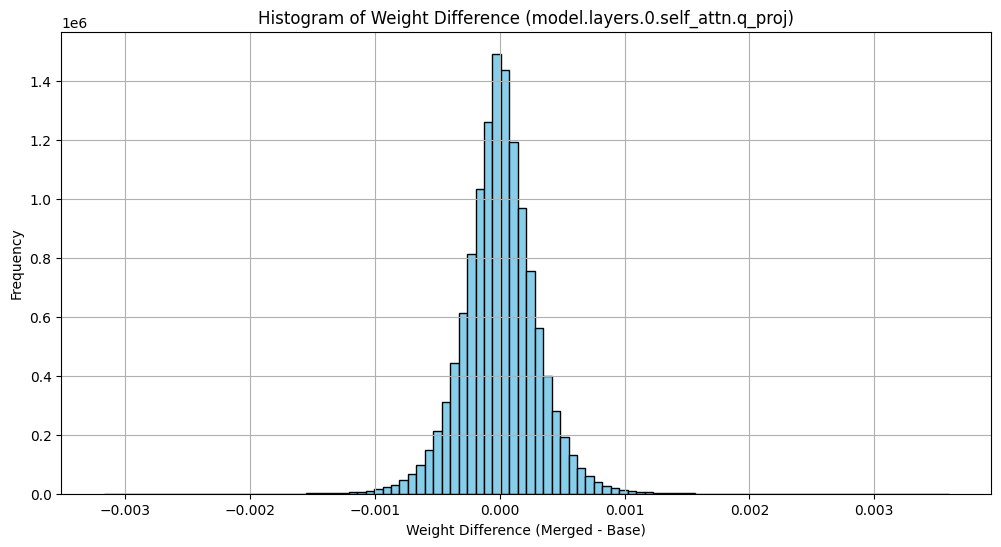

In [3]:
# --- 3. 计算并可视化权重差异 ---
weight_difference = merged_layer_weight - base_layer_weight

print(f"基础模型中 '{target_layer_name}' 的权重张量形状: {base_layer_weight.shape}")
print(f"权重差异张量的均值: {weight_difference.mean():.9e}")
print(f"权重差异张量的标准差: {weight_difference.std():.4e}")
print(f"权重差异张量的最大值: {weight_difference.max():.4f}")
print(f"权重差异张量的最小值: {weight_difference.min():.4f}")

# 绘制权重差异的直方图
plt.figure(figsize=(12, 6))
plt.hist(weight_difference.numpy().flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Weight Difference ({target_layer_name})')
plt.xlabel('Weight Difference (Merged - Base)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()